In [1]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights
from PIL import Image
import os
import spacy
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
import contractions
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GroupShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Прекод

# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


In [2]:
def load_data():
    path_1 = os.path.expanduser('~/sb5/dsplus_integrated_project_4/to_upload/train_dataset.csv')
    path_2 = os.path.expanduser('~/sb5/dsplus_integrated_project_4/to_upload/CrowdAnnotations.tsv')
    path_3 = os.path.expanduser('~/sb5/dsplus_integrated_project_4/to_upload/ExpertAnnotations.tsv')
    path_4 = os.path.expanduser('~/sb5/dsplus_integrated_project_4/to_upload/test_queries.csv')
    train_data = pd.read_csv(path_1)
    crowd_data = pd.read_csv(path_2,
                             header=None, 
                             sep='\t', 
                             names=['image', 'query_id', 'prc', 'quantity_say_yes', 'quantity_say_no'])
    expert_data = pd.read_csv(path_3,
                              header=None,
                              sep='\t',
                              names=['image', 'query_id', 'grade_1', 'grade_2', 'grade_3'])
    test_data = pd.read_csv(path_4, sep='|')
      
    return train_data, crowd_data, expert_data, test_data    

In [3]:
train_data, crowd_data, expert_data, test_data = load_data()

In [4]:
train_data.head()

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


In [6]:
train_data['image'].nunique()

1000

In [7]:
crowd_data.head()

,image,query_id,prc,quantity_say_yes,quantity_say_no
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3


In [8]:
crowd_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   image             47830 non-null  object 
 1   query_id          47830 non-null  object 
 2   prc               47830 non-null  float64
 3   quantity_say_yes  47830 non-null  int64  
 4   quantity_say_no   47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


In [9]:
crowd_data['image'].nunique()

1000

In [10]:
expert_data.head()

,image,query_id,grade_1,grade_2,grade_3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


In [11]:
expert_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   grade_1   5822 non-null   int64 
 3   grade_2   5822 non-null   int64 
 4   grade_3   5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB


In [12]:
expert_data['image'].nunique()

1000

In [13]:
test_data = test_data.drop(columns=['Unnamed: 0'], axis=1)
test_data.head()

,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg


In [14]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 11.8+ KB


In [15]:
test_data['image'].nunique()

100

In [16]:
expert_data.head()

,image,query_id,grade_1,grade_2,grade_3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


In [17]:
expert_data['num_unique_grade'] = expert_data[['grade_1', 'grade_2', 'grade_3']].nunique(axis=1)
expert_data.head()

,image,query_id,grade_1,grade_2,grade_3,num_unique_grade
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2,2


In [18]:
expert_data['num_unique_grade'] = expert_data[['grade_1', 'grade_2', 'grade_3']].nunique(axis=1)
expert_data = expert_data[expert_data['num_unique_grade'] != 3]
expert_data['expert_grade'] = expert_data[['grade_1', 'grade_2', 'grade_3']].mode(axis=1)[0]
expert_data['grade_exp'] = expert_data['expert_grade'].apply(lambda x: 1 if x > 2 else 0 )
agregate_expert_data = expert_data[['image', 'query_id', 'grade_exp']]
agregate_expert_data.head()

,image,query_id,grade_exp
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,0
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,0
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,0
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,0


In [19]:
crowd_data['crowd_grade'] = crowd_data['prc'].apply(lambda x: 1 if x >0.5 else 0)
agregate_crowd_data = crowd_data[['image', 'query_id', 'crowd_grade']]
agregate_crowd_data.head()

,image,query_id,crowd_grade
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0


In [20]:
merged_data = pd.merge(agregate_expert_data, agregate_crowd_data, on=['image', 'query_id'], how='inner')
merged_data['final_grade'] = merged_data['grade_exp'] * 0.6 +  merged_data['crowd_grade'] * 0.4
merged_data['target'] = merged_data['final_grade'].apply(lambda x: 1 if x > 0.5 else 0)
final_data = merged_data[['image', 'query_id', 'target']]
final_data.head()

,image,query_id,target
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,0
2,1056338697_4f7d7ce270.jpg,434792818_56375e203f.jpg#2,0
3,1084040636_97d9633581.jpg,256085101_2c2617c5d0.jpg#2,1
4,1084040636_97d9633581.jpg,3396157719_6807d52a81.jpg#2,0


In [21]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2258 entries, 0 to 2257
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     2258 non-null   object
 1   query_id  2258 non-null   object
 2   target    2258 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 53.1+ KB


## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

In [22]:
train_data['query_text'].unique()

array(['A young child is wearing blue goggles and sitting in a float in a pool .',
       'A girl wearing a yellow shirt and sunglasses smiles .',
       'A man sleeps under a blanket on a city street .',
       'A woman plays with long red ribbons in an empty square .',
       'Chinese market street in the winter time .',
       'A soccer ball is above the head of a man wearing black shorts and red and black striped shirt .',
       'A young boy dressed in a red uniform kicks the soccer ball on the field as another child in blue watches from behind .',
       'A man and woman look back at the camera while standing in front of a red art structure .',
       'A white dog jumps to catch a blue ball in a living room .',
       'A little boy shakes the snow off of a tree .',
       'The kid is on a float in the snow .',
       'Two long-haired puppy dogs have a romp in the snow .',
       'A little girl wearing sunglasses puts her feet into the kitchen sink .',
       'Snowboarder in the a

## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [ ]:
# Модель ResNet-18
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model = torch.nn.Sequential(*list(model.children())[:-1])  # Убираем последний слой
# model.eval()  # Переводим в режим оценки

In [ ]:
# Простая трансформация для изображений
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# Функция для извлечения векторов
def extract_vector(image_path):
    image = Image.open(image_path).convert('RGB')  # Открытие изображения
    image = transform(image).unsqueeze(0)  # Преобразование в формат батча
    with torch.no_grad():
        vector = model(image).flatten().numpy()  # Преобразование в плоский вектор
    return vector

In [ ]:
# Папка с изображениями
image_folder = os.path.expanduser('~/sb5/dsplus_integrated_project_4/to_upload/train_images')
data = []

# Обработка всех изображений в папке
for image_name in os.listdir(image_folder):
    image_path = os.path.join(image_folder, image_name)
    try:
        vector = extract_vector(image_path)  # Извлечение вектора
        data.append({'image_name': image_name, 'vector': vector})  # Добавляем в список
    except Exception as e:
        print(f"Ошибка обработки изображения {image_name}: {e}") 

In [24]:
df_vectors = pd.DataFrame(data)
df_vectors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_name  1000 non-null   object
 1   vector      1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB


In [25]:
df_vectors.head()

,image_name,vector
0,1056338697_4f7d7ce270.jpg,"[0.80264, 3.3572319, 2.5146577, 0.9421949, 1.5..."
1,106490881_5a2dd9b7bd.jpg,"[0.40738517, 0.21095507, 0.60640675, 0.6588585..."
2,1082379191_ec1e53f996.jpg,"[0.7295891, 0.20299795, 1.855079, 0.58034056, ..."
3,1084040636_97d9633581.jpg,"[0.40231404, 0.18350258, 0.283624, 0.10579517,..."
4,1096395242_fc69f0ae5a.jpg,"[1.6502961, 1.8862208, 0.5797508, 1.9919134, 1..."


In [26]:
array_data = np.array(df_vectors['vector'].tolist())  # Преобразуем столбец vector в массив
df_new = pd.DataFrame(array_data, columns=[f"feature_{i}" for i in range(array_data.shape[1])])
df_new.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_502,feature_503,feature_504,feature_505,feature_506,feature_507,feature_508,feature_509,feature_510,feature_511
0,0.802640,3.357232,2.514658,0.942195,1.508516,2.346695,0.314035,0.702477,0.615567,0.231446,...,0.637276,0.219047,0.384096,1.079534,1.404953,0.688937,1.954983,0.161946,0.782466,0.064423
1,0.407385,0.210955,0.606407,0.658859,0.120567,0.634342,0.413995,4.073375,0.304004,0.125120,...,0.146575,0.304207,0.578395,1.017992,1.615013,0.926651,0.169578,0.841979,5.125371,0.773034
2,0.729589,0.202998,1.855079,0.580341,0.626553,0.143646,0.037639,0.836638,0.223689,0.402279,...,0.153444,0.583726,0.239172,1.036998,0.296971,0.262911,0.102949,0.511674,1.811105,0.455383
3,0.402314,0.183503,0.283624,0.105795,1.727308,1.006570,2.444504,2.763435,0.632619,2.655972,...,1.638171,0.294375,0.634571,1.967474,0.111393,0.337765,1.530849,0.656763,0.998856,0.081258
4,1.650296,1.886221,0.579751,1.991913,1.071766,0.766749,0.068952,1.567754,0.868545,0.976813,...,1.215463,0.969691,1.459169,0.351211,1.653974,1.217975,0.488564,1.348823,0.978178,1.010952


In [27]:
df_combined = pd.concat([df_vectors, df_new], axis=1)
df_combined.drop(columns=['vector'], axis=1, inplace=True)
df_combined.head()

,image_name,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_502,feature_503,feature_504,feature_505,feature_506,feature_507,feature_508,feature_509,feature_510,feature_511
0,1056338697_4f7d7ce270.jpg,0.802640,3.357232,2.514658,0.942195,1.508516,2.346695,0.314035,0.702477,0.615567,...,0.637276,0.219047,0.384096,1.079534,1.404953,0.688937,1.954983,0.161946,0.782466,0.064423
1,106490881_5a2dd9b7bd.jpg,0.407385,0.210955,0.606407,0.658859,0.120567,0.634342,0.413995,4.073375,0.304004,...,0.146575,0.304207,0.578395,1.017992,1.615013,0.926651,0.169578,0.841979,5.125371,0.773034
2,1082379191_ec1e53f996.jpg,0.729589,0.202998,1.855079,0.580341,0.626553,0.143646,0.037639,0.836638,0.223689,...,0.153444,0.583726,0.239172,1.036998,0.296971,0.262911,0.102949,0.511674,1.811105,0.455383
3,1084040636_97d9633581.jpg,0.402314,0.183503,0.283624,0.105795,1.727308,1.006570,2.444504,2.763435,0.632619,...,1.638171,0.294375,0.634571,1.967474,0.111393,0.337765,1.530849,0.656763,0.998856,0.081258
4,1096395242_fc69f0ae5a.jpg,1.650296,1.886221,0.579751,1.991913,1.071766,0.766749,0.068952,1.567754,0.868545,...,1.215463,0.969691,1.459169,0.351211,1.653974,1.217975,0.488564,1.348823,0.978178,1.010952


## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


In [28]:
nlp = spacy.load("en_core_web_sm")

In [29]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Андрей\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
def lematize_text(text):
    text = text
    expanded_text = contractions.fix(text)
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', expanded_text).lower().replace('\n', ' ').replace('\r', ' ').replace('  ', ' ')
    doc = nlp(cleaned_text)
    lemmas = [token.lemma_ for token in doc]
    filtered_tokens = [word for word in lemmas if word not in stop_words]
    lemmatized = " ".join(filtered_tokens)
    return lemmatized  

In [31]:
lemmatized_results = []
for i in tqdm(range(0, 5822)):
    lemmatized = lematize_text(train_data['query_text'][i])
    lemmatized_results.append(lemmatized)

100%|█████████████████████████████████████████████████████████████████████████████| 5822/5822 [00:23<00:00, 247.98it/s]


In [32]:
train_data['lemmatized_text'] = pd.Series(lemmatized_results)
train_data.head()

,image,query_id,query_text,lemmatized_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,young child wear blue goggle sit float pool
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,young child wear blue goggle sit float pool
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,young child wear blue goggle sit float pool
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,young child wear blue goggle sit float pool
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,young child wear blue goggle sit float pool


In [33]:
corpus = train_data['lemmatized_text']
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(corpus)
tfidf_matrix.shape

(5822, 1188)

In [34]:
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=vectorizer.get_feature_names_out()
)
tfidf_df.head()

,across,action,actor,adult,aerial,aerodynamically,african,aged,ahead,aim,...,wrap,wrestle,wring,wrinkle,write,yard,yellow,yerba,young,youth
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.278159,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.278159,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.278159,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.278159,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.278159,0.0


## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [35]:
combined_data = pd.concat([train_data, tfidf_df], axis=1)
combined_data.drop(columns=['query_text', 'lemmatized_text'], axis=1, inplace=True)
combined_data.head()

,image,query_id,across,action,actor,adult,aerial,aerodynamically,african,aged,...,wrap,wrestle,wring,wrinkle,write,yard,yellow,yerba,young,youth
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.278159,0.0
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.278159,0.0
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.278159,0.0
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.278159,0.0
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.278159,0.0


In [36]:
merged_df = pd.merge(combined_data, df_combined, left_on='image', right_on='image_name', how='inner')
merged_df.head()

,image,query_id,across,action,actor,adult,aerial,aerodynamically,african,aged,...,feature_502,feature_503,feature_504,feature_505,feature_506,feature_507,feature_508,feature_509,feature_510,feature_511
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.637276,0.219047,0.384096,1.079534,1.404953,0.688937,1.954983,0.161946,0.782466,0.064423
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.256134,0.383169,0.766559,0.958161,0.767122,1.412815,0.572392,0.649989,0.094356,1.365769
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.115227,0.951246,1.576933,0.185818,1.406764,1.644087,1.142907,0.487311,1.686374,1.365325
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.664370,0.049247,0.425441,0.234108,2.892038,1.186666,0.121490,0.370115,1.542130,0.935158
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.895655,0.469737,1.316280,1.893028,4.764876,0.763958,0.519451,1.884192,0.679976,1.014401


In [37]:
merged_final_df = pd.merge(merged_df, final_data, left_on='query_id', right_on='query_id', how='inner')
merged_final_df.head()

,image_x,query_id,across,action,actor,adult,aerial,aerodynamically,african,aged,...,feature_504,feature_505,feature_506,feature_507,feature_508,feature_509,feature_510,feature_511,image_y,target
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.384096,1.079534,1.404953,0.688937,1.954983,0.161946,0.782466,0.064423,1056338697_4f7d7ce270.jpg,0
1,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.384096,1.079534,1.404953,0.688937,1.954983,0.161946,0.782466,0.064423,2447284966_d6bbdb4b6e.jpg,0
2,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.384096,1.079534,1.404953,0.688937,1.954983,0.161946,0.782466,0.064423,2549968784_39bfbe44f9.jpg,1
3,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.384096,1.079534,1.404953,0.688937,1.954983,0.161946,0.782466,0.064423,3030566410_393c36a6c5.jpg,0
4,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.384096,1.079534,1.404953,0.688937,1.954983,0.161946,0.782466,0.064423,3718964174_cb2dc1615e.jpg,0


## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

In [38]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=merged_final_df.drop(columns=['target', 'image_y']), 
                                             y=merged_final_df['target'], 
                                             groups=merged_final_df['image_x']))
train_df, test_df = merged_final_df.loc[train_indices], merged_final_df.loc[test_indices]

In [39]:
X_train = train_df.drop(columns=['target', 'image_y', 'image_x', 'query_id', 'image_name'])
y_train = train_df['target']
X_test = test_df.drop(columns=['target', 'image_y', 'image_x', 'query_id', 'image_name'])
y_test = test_df['target']

In [40]:
model_rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

In [41]:
model_rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [42]:
y_pred = model_rf.predict(X_test)

In [43]:
accuracy = accuracy_score(y_test, y_pred)

In [44]:
print(f'Accuracy: {accuracy: .4f}')

Accuracy:  0.6636


In [45]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.98      0.79      4015
           1       0.75      0.10      0.17      2257

    accuracy                           0.66      6272
   macro avg       0.70      0.54      0.48      6272
weighted avg       0.69      0.66      0.57      6272



## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

In [46]:
# Пути к данным
test_image_folder = os.path.expanduser('~/sb5/dsplus_integrated_project_4/to_upload/test_images')
test_queries_file = os.path.expanduser('~/sb5/dsplus_integrated_project_4/to_upload/test_queries.csv')

In [47]:
# Загружаем тестовые запросы
test_queries = pd.read_csv(test_queries_file, sep='|')

In [48]:
# Проверяем названия колонок
print(test_queries.columns)  

Index(['Unnamed: 0', 'query_id', 'query_text', 'image'], dtype='object')


In [49]:
# 10 случайных запросов
random_queries = test_queries.sample(n=10, random_state=42)

In [50]:
# Загружаем ResNet-18
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model = torch.nn.Sequential(*list(model.children())[:-1])
# model.eval()

In [51]:
# Трансформация изображений
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [52]:
# Функция извлечения вектора
def extract_vector(image_path):
    if not os.path.exists(image_path):
        print(f"Файл не найден: {image_path}")
        return None
    
    image = Image.open(image_path).convert('RGB')  
    image = transform(image).unsqueeze(0)  
    with torch.no_grad():
        vector = model(image).flatten().numpy()  
    return vector

In [53]:
# Создаём словарь эмбеддингов изображений
image_embeddings = {}

for image_name in os.listdir(test_image_folder):
    image_path = os.path.join(test_image_folder, image_name)
    try:
        vector = extract_vector(image_path)
        if vector is not None:
            image_embeddings[image_name] = vector
    except Exception as e:
        print(f"Ошибка обработки изображения {image_name}: {e}") 

In [54]:
# Преобразуем словарь в DataFrame
image_embeddings_df = pd.DataFrame.from_dict(image_embeddings, orient='index')
image_embeddings_df.reset_index(inplace=True)
image_embeddings_df.rename(columns={'index': 'image_name'}, inplace=True)

In [55]:
# Функция поиска наиболее похожего изображения
def find_most_similar_image(query_embedding, image_embeddings_df):
    image_vectors = image_embeddings_df.drop(columns=['image_name']).values
    similarity_scores = cosine_similarity([query_embedding], image_vectors)[0]
    best_match_index = np.argmax(similarity_scores)
    return image_embeddings_df.iloc[best_match_index]['image_name']

In [56]:
# Ищем наиболее похожие изображения
results = []

for _, row in random_queries.iterrows():
    # Убираем суффикс (#1, #2) из имени файла
    query_image_name = row['query_id'].split('#')[0]
    query_image_path = os.path.join(test_image_folder, query_image_name)

    query_embedding = extract_vector(query_image_path)
    
    if query_embedding is None:
        print(f"Пропущен запрос {row['query_id']} (файл не найден)")
        continue  # Пропускаем итерацию

    best_match = find_most_similar_image(query_embedding, image_embeddings_df)
    results.append((row['query_id'], best_match))

print("Результаты поиска готовы.")

Результаты поиска готовы.


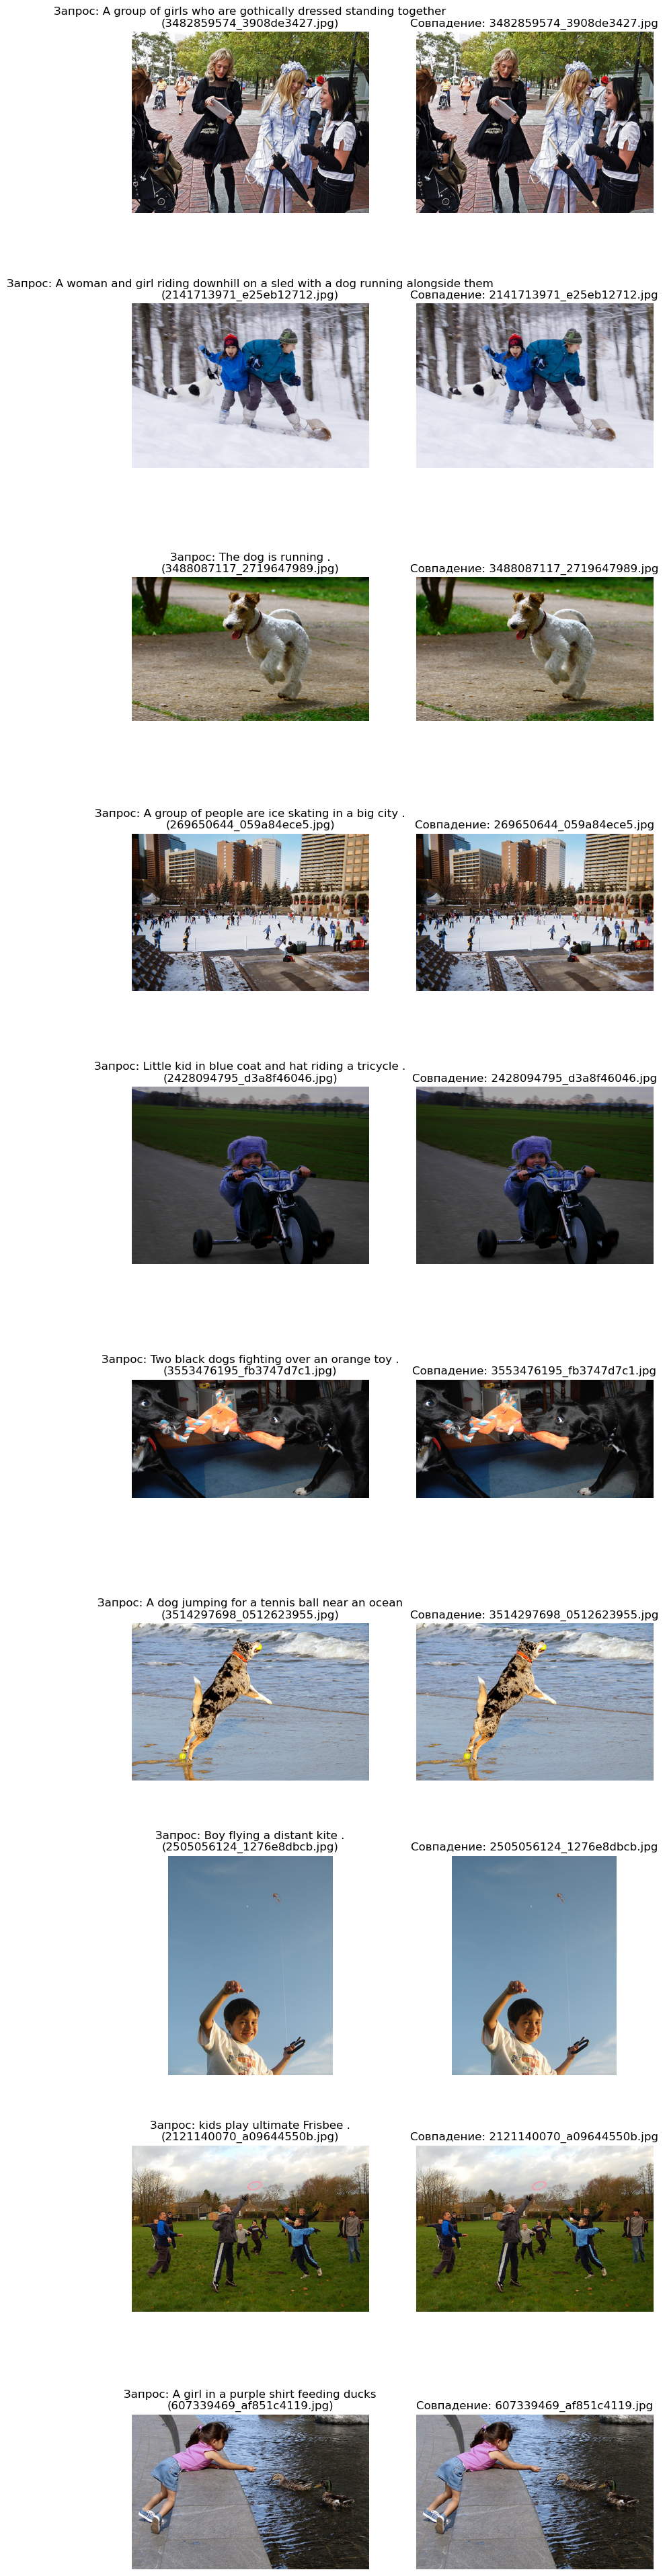

In [57]:
# Визуализация результатов
fig, axes = plt.subplots(len(results), 2, figsize=(10, 5 * len(results)))

for i, (query_id, matched_image) in enumerate(results):
    # Убираем `#1`, `#2` из имени файла
    query_image_name = query_id.split('#')[0]
    matched_image_name = matched_image.split('#')[0]

    query_image_path = os.path.join(test_image_folder, query_image_name)
    matched_image_path = os.path.join(test_image_folder, matched_image_name)

    # Находим текстовый запрос для query_id
    query_text = test_queries.loc[test_queries['query_id'] == query_id, 'query_text'].values[0]

      # Загружаем изображения
    query_img = Image.open(query_image_path)
    matched_img = Image.open(matched_image_path)
    
    axes[i, 0].imshow(query_img)
    axes[i, 0].set_title(f"Запрос: {query_text}\n({query_image_name})")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(matched_img)
    axes[i, 1].set_title(f"Совпадение: {matched_image_name}")
    axes[i, 1].axis("off")

plt.show()

## 8. Выводы

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Проверены экспертные оценки и краудсорсинговые оценки
- [ ]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [ ]  Изображения векторизованы
- [ ]  Текстовые запросы векторизованы
- [ ]  Данные корректно разбиты на тренировочную и тестовую выборки
- [ ]  Предложена метрика качества работы модели
- [ ]  Предложена модель схожести изображений и текстового запроса
- [ ]  Модель обучена
- [ ]  По итогам обучения модели сделаны выводы
- [ ]  Проведено тестирование работы модели
- [ ]  По итогам тестирования визуально сравнили качество поиска